# Time Series and FFT

* sadece ilk 0.1 saniyesini kullanıldı.
* FFT (Hızlı Fourier Dönüşümü) sonuçlarında en fazla 8000 Hz'e kadar olan frekanslar gösterildi.
* FFT (Hızlı Fourier Dönüşümü) elde edilen magnitüd değerlerini normalize edildi ve ölçeklendirildi. Özellikle, magnitüd değerlerini 0 ile 175000 arasında bir değer aralığına dönüştürmek için tasarlanmıştır.

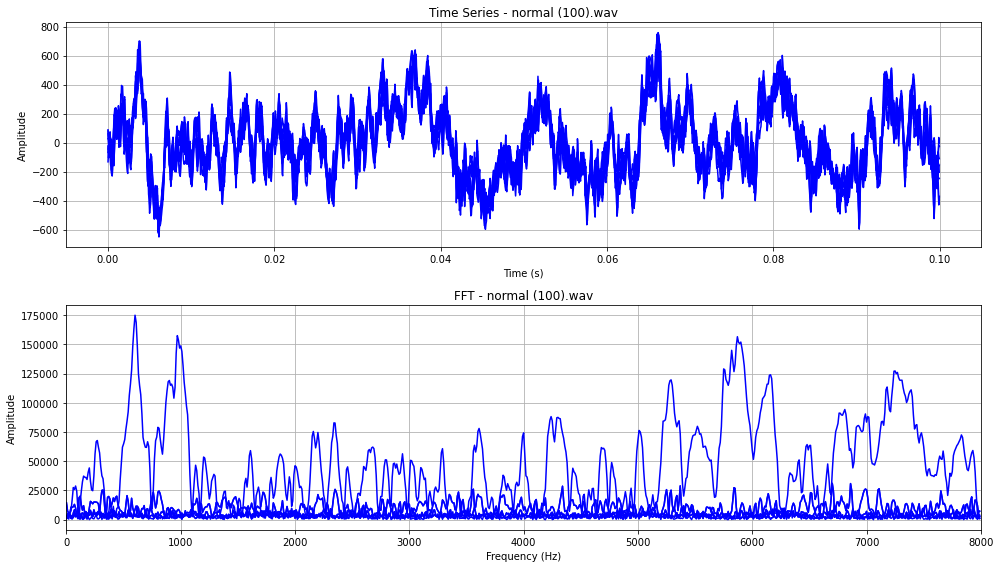

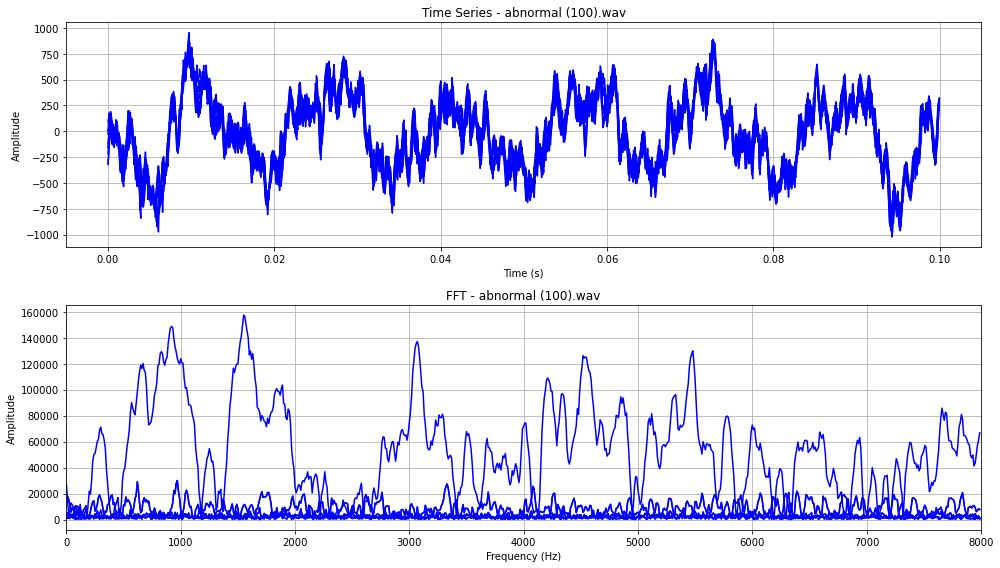

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

def analyze_wav_files(wav_folder_path, file_names=None, time_slice=None, max_freq=None):
    """
    Belirtilen WAV dosyalarını normalleştirilmiş genliklerle zaman serisine ve frekansa (FFT yoluyla) dönüştürerek analiz edin
    ve sonuçların görselleştirilmesi.

    Argümanlar:
        wav_folder_path (str): WAV dosyalarını içeren klasörün yolu.
        file_names (liste): Görselleştirilecek dosya adlarının listesi. Yok ise, tüm dosyaları görselleştirir.
        time_slice (tuple): Odaklanılacak saniye cinsinden (başlangıç, bitiş) zaman dilimi.
        max_freq (float): FFT çiziminde görüntülenecek maksimum frekans.

    """
    if not os.path.isdir(wav_folder_path):
        print("Error: Specified folder not found.")
        return

    available_files = [f for f in os.listdir(wav_folder_path) if f.endswith('.wav')]
    if file_names is None:
        file_names = available_files
    else:
        file_names = [f for f in file_names if f in available_files]

    for file_name in file_names:
        file_path = os.path.join(wav_folder_path, file_name)
        rate, data = wavfile.read(file_path)
        
        if time_slice:
            start_idx = int(time_slice[0] * rate)
            end_idx = int(time_slice[1] * rate)
            data = data[start_idx:end_idx]

        # Time series plot
        time = np.arange(0, len(data)) / rate
        plt.figure(figsize=(14, 8))
        plt.subplot(2, 1, 1)
        plt.plot(time, data, color='blue')  # Set color to blue for all plots
        plt.title(f"Time Series - {file_name}")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.grid(True)

        # FFT ve frequency plot
        fft_result = np.fft.fft(data)
        freqs = np.fft.fftfreq(len(data), 1/rate)
        magnitude = np.abs(fft_result)
        normalized_magnitude = 175000 * magnitude / np.max(magnitude)  # Normalize and scale the magnitude

        plt.subplot(2, 1, 2)
        plt.plot(freqs[:len(freqs)//2], normalized_magnitude[:len(magnitude)//2], color='blue')  # Set color to blue for all plots
        plt.title(f"FFT - {file_name}")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Amplitude")
        plt.grid(True)

        if max_freq:
            plt.xlim([0, max_freq])

        plt.tight_layout()
        plt.show()


wav_folder_path = "/Users/Sema/Desktop/Acoustic"
file_names = ['normal (100).wav', 'abnormal (100).wav']
analyze_wav_files(wav_folder_path, file_names=file_names, time_slice=(0, 0.1), max_freq=8000)


In [2]:
import os
from scipy.io import wavfile

def analyze_wav_files(wav_folder_path):
    if not os.path.isdir(wav_folder_path):
        print("Error: Specified folder not found.")
        return

    available_files = [f for f in os.listdir(wav_folder_path) if f.endswith('.wav')]
    
    total_samples = 0
    for file_name in available_files:
        file_path = os.path.join(wav_folder_path, file_name)
        rate, data = wavfile.read(file_path)
        total_samples += len(data)

    print("Total number of files:", len(available_files))
    print("Total number of samples across all files:", total_samples)

# Kullanım örneği:
wav_folder_path = "/Users/Sema/Desktop/Acoustic"
analyze_wav_files(wav_folder_path)


Total number of files: 814
Total number of samples across all files: 130240000


# Spektrogram 

Mono Kontrolü:

if len(data.shape) > 1:
    data = data.mean(axis=1)

* Eğer veri çok kanallı (stereo gibi) ise, kanalların ortalaması alınarak mono bir formata dönüştürülür.

This modification handles multi-channel WAV files by converting them to mono. It calculates the mean across channels with np.mean(data, axis=1), which is a common method for downmixing stereo to mono when the channel-specific information isn't critical for the analysis. 



Spektrogram Çizimi:

* librosa.stft: Kısa Zamanlı Fourier Dönüşümü hesaplanır.
* librosa.amplitude_to_db: Amplitüd dB cinsinden hesaplanır.
* librosa.display.specshow: Spektrogram gösterilir. x_axis='time', y_axis='hz' ile eksenler zaman ve frekans olarak ayarlanır.
* plt.colorbar: Renk barı eklendiğinde, dB cinsinden değerler gösterilir.
* plt.tight_layout: Grafiğin düzgün görünmesi için layout optimize edilir.

C:\Users\Sema\anaconda3\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1600
  warnings.warn(


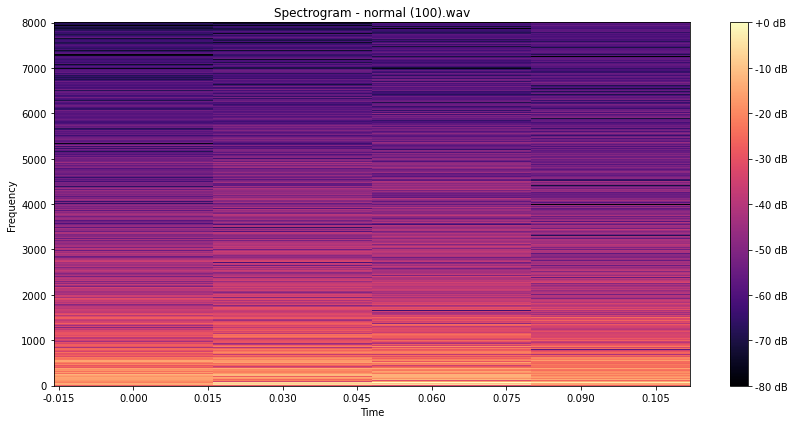

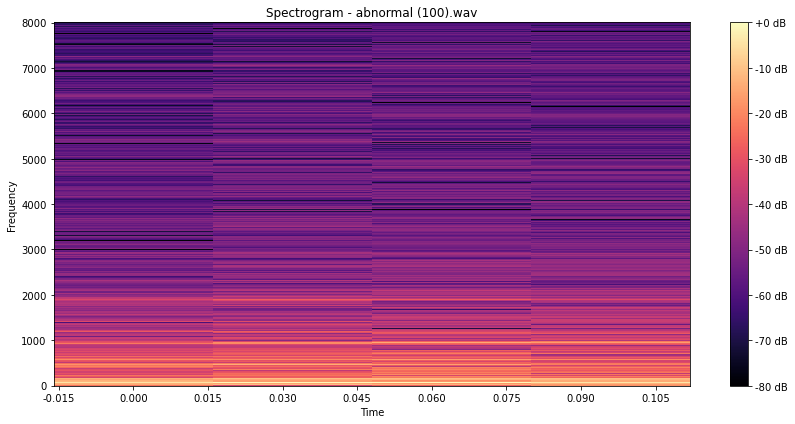

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import librosa
import librosa.display

def analyze_wav_files(wav_folder_path, file_names=None, time_slice=None):
    if not os.path.isdir(wav_folder_path):
        print("Error: Specified folder not found.")
        return

    available_files = [f for f in os.listdir(wav_folder_path) if f.endswith('.wav')]
    if file_names is None:
        file_names = available_files
    else:
        file_names = [f for f in file_names if f in available_files]

    for file_name in file_names:
        file_path = os.path.join(wav_folder_path, file_name)
        rate, data = wavfile.read(file_path)
        
        if time_slice:
            start_idx = int(time_slice[0] * rate)
            end_idx = int(time_slice[1] * rate)
            data = data[start_idx:end_idx]

        # monoya çevirme eğer veri stereo ise
        if len(data.shape) > 1:
            data = data.mean(axis=1)

        # Spectrogram oluşturma
        plt.figure(figsize=(12, 6))
        D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
        librosa.display.specshow(D, sr=rate, x_axis='time', y_axis='hz')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f"Spectrogram - {file_name}")
        plt.xlabel("Time")
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()


wav_folder_path = "/Users/Sema/Desktop/Acoustic"
file_names = ['normal (100).wav', 'abnormal (100).wav']
analyze_wav_files(wav_folder_path, file_names=file_names, time_slice=(0, 0.1))


* 0 dB'ye Yaklaşmak: Spektrogramda bir sesin 0 dB'ye yaklaşması, bu sesin referans güç seviyesine eşit güçte olduğunu gösterir. Pratikte, bu sesin oldukça güçlü olduğu anlamına gelir, çünkü spektrogram genellikle maksimum ses seviyesini referans alarak ayarlanır. Bu, o frekansta sesin oldukça yüksek bir yoğunluğa sahip olduğunu gösterir.

* Eksi Desibel Değerleri: Sesin eksi desibel değerlerinde kalması, referans seviyesinden daha düşük güçte olduğunu gösterir. Desibel ölçeği logaritmik olduğundan, negatif değerler ses şiddetinin referans seviyesinden daha düşük olduğunu belirtir. Örneğin, -20 dB, referans seviyesinin 100 kat daha düşük bir güç seviyesi anlamına gelir. Pratikte, eksi desibel değerleri, sesin daha zayıf veya daha az enerjik olduğu anlamına gelir.

In [4]:
for file_name in file_names:
    file_path = os.path.join(wav_folder_path, file_name)
    rate, data = wavfile.read(file_path)

    # rate and data içeriğine bakma
    print(f"File: {file_name}")
    print(f"Sampling Rate: {rate} Hz")
    print(f"Data Type: {data.dtype}")
    print(f"Number of Samples: {len(data)}")
    print(f"First 5 Samples: {data[:5]}")


File: normal (100).wav
Sampling Rate: 16000 Hz
Data Type: int16
Number of Samples: 160000
First 5 Samples: [[ -45 -133  -68  -24   60   88   80   26]
 [ -15  -49  -37 -106    1   -4   40   24]
 [   2  -52   17  -57  -90   -5    8   39]
 [  31  -48   29  -68  -86  -22   12   -5]
 [  74    6  -19 -100  -88  -78  -24   14]]
File: abnormal (100).wav
Sampling Rate: 16000 Hz
Data Type: int16
Number of Samples: 160000
First 5 Samples: [[   9 -119 -217 -310 -323 -157  -30   92]
 [  23  -59 -115 -247 -243 -125   89  117]
 [   6  -54 -151 -143 -126   63  176   87]
 [  67  -64  -54  -37  -29  151  167   73]
 [ -28   11   46   45   89  138   73  133]]


# Feature Extraction 

1. Time-Domain Features
Some common time-domain features include:
* Amplitude statistics: Mean, median, standard deviation, min, and max values.
* Energy: Sum of squares of the amplitudes.
* Zero Crossing Rate: The rate at which the signal changes from positive to negative or back.
2. Frequency-Domain Features
After applying FFT, you can extract:
* Spectral Centroid: Indicates where the center of mass of the spectrum is located.
* Spectral Roll-off: Frequency below which a specified percentage of the total spectral energy lies.
* Spectral Flux: Measures the change in the power spectrum from one frame to the next.
* Band Energy Ratio: Energy in specific frequency bands compared to total energy.

1. After reading the WAV file with wavfile.read, you should convert the sample values to float. This can be done by dividing the integers by their maximum possible value based on their bit depth (e.g., 32768 for 16-bit audio).
2. Instead of using wavfile.read, you can directly use librosa.load, which automatically handles conversion to floating-point, resampling to a given sample rate, and can read only a specific duration from the file which might be more efficient.

In [5]:
import os
import numpy as np
import librosa
import scipy.stats
import scipy.fft

def band_power(y, sr, low_freq, high_freq):
    # FFT hesaplama
    fft_spectrum = scipy.fft.fft(y)
    fft_magnitude = np.abs(fft_spectrum) ** 2
    frequencies = np.linspace(0, sr, len(fft_magnitude))
    
    # Belirli bir bant aralığındaki güç toplamını hesaplama
    idx_band = np.where((frequencies >= low_freq) & (frequencies <= high_freq))[0]
    band_power = np.sum(fft_magnitude[idx_band])
    return band_power

def extract_features(file_path, start_sample, duration_samples, sr):
    y, _ = librosa.load(file_path, sr=sr, mono=True, offset=start_sample/sr, duration=duration_samples/sr)

    # Spektral özellikler
    S, phase = librosa.magphase(librosa.stft(y))
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    spectral_flatness = np.mean(librosa.feature.spectral_flatness(y=y))

    # Zero Crossing Rate
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=y))

    # MFCC
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1)

    # Chromagram
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr), axis=1)

    # FFT ile frekans analizi
    fft_spectrum = scipy.fft.fft(y)
    fft_magnitude = np.abs(fft_spectrum) ** 2
    frequencies = np.linspace(0, sr, len(fft_magnitude))

    # Toplam Güç
    total_power = np.sum(fft_magnitude)

    # Maksimum Güç Frekansı
    max_power_freq = frequencies[np.argmax(fft_magnitude)]

    # Band Power for the 300-3400 Hz band
    voice_band_power = band_power(y, sr, 300, 3400)

    # Tüm özellikleri birleştirme
    features = np.hstack([spectral_centroid, spectral_rolloff, spectral_bandwidth, spectral_flatness, zcr, mfccs, chroma, voice_band_power, total_power, max_power_freq])
    return features

def analyze_wav_files(wav_folder_path, sample_duration=0.1, num_samples=10):
    if not os.path.isdir(wav_folder_path):
        print("Error: Specified folder not found.")
        return

    available_files = [f for f in os.listdir(wav_folder_path) if f.endswith('.wav')]
    all_features = []

    for file_name in available_files:
        file_path = os.path.join(wav_folder_path, file_name)
        sr = librosa.get_samplerate(file_path)
        file_length_seconds = librosa.get_duration(filename=file_path)

        duration_samples = int(sample_duration * sr)
        if file_length_seconds > sample_duration:
            sample_points = np.linspace(0, file_length_seconds - sample_duration, num_samples)
            for start_time in sample_points:
                start_sample = int(start_time * sr)
                features = extract_features(file_path, start_sample, duration_samples, sr)
                all_features.append(features)

    return np.array(all_features)

wav_folder_path = "/Users/Sema/Desktop/Acoustic"
features_matrix = analyze_wav_files(wav_folder_path)
print(features_matrix)

C:\Users\Sema\AppData\Local\Temp\ipykernel_13200\3533164874.py:66: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  file_length_seconds = librosa.get_duration(filename=file_path)
C:\Users\Sema\anaconda3\lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


[[1506.92073248 3666.015625   1935.12284668 ...    9.9210844
    93.20139313   70.04377736]
 [1473.27892759 3423.828125   1889.69772326 ...   11.94615841
   137.56469727   70.04377736]
 [1633.56825679 3775.390625   1948.64036906 ...    7.87331724
    67.78663635   60.03752345]
 ...
 [2229.81355397 4865.234375   2127.9192977  ...   11.44157505
    62.18592072   70.04377736]
 [2220.1237434  4787.109375   2112.81707683 ...   12.54618645
    69.07408142   70.04377736]
 [2109.74167184 4527.34375    2061.70078988 ...   14.09823418
    74.95678711   60.03752345]]


1. Sayısal Gösterim ve Kayan Nokta Hassasiyeti:
Veri işleme ve saklama sürecinde, kayan noktalı (floating point) sayıların hassasiyetinde ufak değişiklikler olabilir. Örneğin, numpy ve diğer bilimsel hesaplama kütüphaneleri, hesaplamalar sırasında çeşitli sayısal optimizasyonlar uygular. Bu optimizasyonlar, sayıların nasıl saklandığına ve gösterildiğine bağlı olarak hafif değişikliklere neden olabilir.

Python ve numpy'da standart kayan nokta sayıları float64 (64-bit kayan nokta) olarak saklanır. Bu format, sayıları belirli bir hassasiyetle saklar ve gösterir. Ekleme işlemi veya hesaplama sırasında yapılan herhangi bir değişiklik, sonuçların gösteriminde küçük farklılıklar yaratabilir.

Spektral Özellikler:

* Spectral Centroid, Rolloff, Bandwidth, ve Flatness: Bu özellikler sesin tonal ve harmonik içeriğini yansıtan spektral özelliklerdir. librosa.feature fonksiyonları bu özellikleri hesaplar.

* Zero Crossing Rate (ZCR): Ses dalgasının sıfır çizgisini ne sıklıkta kestiğini gösterir. ZCR, sesin frekans içeriği hakkında bilgi verir.

* MFCC (Mel-Frequency Cepstral Coefficients):Sesin kısa süreli güç spektrumunu temsil eden katsayılardır ve sesin özelliklerini sıkıştırılmış bir formatta sunar.

Chromagram:
* Ses sinyalinin 12 farklı ton (kromatik notalar) üzerindeki enerji dağılımını gösterir.
FFT (Fast Fourier Transform):
* Ses sinyalini zaman domain'inden frekans domain'ine dönüştürür. Magnitude ve phase bilgileri hesaplanır ve bu bilgiler de özelliklere dahil edilir.

* Özellikleri birleştirmenin amacı, genellikle makine öğrenimi modellemesi için kullanılabilecek kapsamlı bir özellik vektörü oluşturmaktır. Bu vektör, modelin eğitilmesi sırasında girdi olarak kullanılır ve her bir özellik, modelin öğrenmesi için farklı bir yön veya boyut sağlar.

* zero_crossing_rate() fonksiyonu, ses sinyalinin zaman serisi verileri üzerinde çalışır ve her çerçeve (frame) için sinyalin sıfır çizgisini kaç kez kestiğini hesaplar. Bir sinyalin sıfır çizgisini kesmesi, sinyalin pozitif değerlerden negatif değerlere ya da negatif değerlerden pozitif değerlere geçtiği anları ifade eder. Bu özellik, sesin frekans içeriği ve sertlik (roughness) hakkında bilgi verir ve genellikle müzik ve konuşma sinyallerinin analizinde kullanılır.

* Konuşma tanımada, genellikle 12-20 arası MFCC kullanılır. Bu, konuşmanın temel frekans bileşenlerini ve bunların zamanla değişimini yeterince yakalayarak dili ve konuşmacı özelliklerini iyi bir şekilde temsil eder.

* Müzik parçaları, konuşmaya göre genellikle daha karmaşık harmonik yapıya sahiptir. Bu nedenle, müzik analizi için kullanılan MFCC sayısı daha yüksek olabilir. Örneğin, bir müzik parçasının tüm tonal özelliklerini yakalamak için 20-40 MFCC kullanılabilir.

* Ses verileriniz ne kadar karmaşık ve çeşitliyse (örneğin, farklı ortamlardan kaydedilmiş, farklı konuşmacılar, arka plan gürültüsü vb.), modelinizin bu çeşitliliği öğrenmesi için daha fazla MFCC gerekebilir. Daha fazla MFCC, ses sinyalinden daha fazla bilgi çıkarılmasını sağlar, ancak aynı zamanda işlem yükünü ve modelin overfitting (aşırı uyum) riskini artırabilir.

In [6]:
features_matrix.shape

(8140, 33)

In [7]:
import os
import librosa

def calculate_segment_samples(wav_folder_path, segment_duration=0.1, num_samples_per_file=10):
    if not os.path.isdir(wav_folder_path):
        print("Error: Specified folder not found.")
        return None

    available_files = [f for f in os.listdir(wav_folder_path) if f.endswith('.wav')]
    segment_lengths = []

    for file_name in available_files:
        file_path = os.path.join(wav_folder_path, file_name)
        # Dosyayı yükle ve örneklem oranını al
        y, sr = librosa.load(file_path, sr=None)
        # Segment uzunluğunu hesapla
        segment_samples = int(segment_duration * sr)
        segment_lengths.append(segment_samples)

    total_samples = sum(segment_lengths) * num_samples_per_file
    print("Each segment contains:", segment_lengths[0], "samples")  # Her segment için örnek sayısını bul
    print("Total samples from all segments:", total_samples)

    return segment_lengths


wav_folder_path = "/Users/Sema/Desktop/Acoustic"
segment_lengths = calculate_segment_samples(wav_folder_path)

Each segment contains: 1600 samples
Total samples from all segments: 13024000


In [8]:
def calculate_feature_samples(total_segments, features_per_segment):
    total_features = total_segments * features_per_segment
    return total_features

# Toplam segment sayısı ve özellik sayısı bilgisi ile hesaplama
total_segments = 8140
features_per_segment = 33
total_features = calculate_feature_samples(total_segments, features_per_segment)
print("Total features from all segments:", total_features)


Total features from all segments: 268620


In [9]:
print(features_matrix)


[[1506.92073248 3666.015625   1935.12284668 ...    9.9210844
    93.20139313   70.04377736]
 [1473.27892759 3423.828125   1889.69772326 ...   11.94615841
   137.56469727   70.04377736]
 [1633.56825679 3775.390625   1948.64036906 ...    7.87331724
    67.78663635   60.03752345]
 ...
 [2229.81355397 4865.234375   2127.9192977  ...   11.44157505
    62.18592072   70.04377736]
 [2220.1237434  4787.109375   2112.81707683 ...   12.54618645
    69.07408142   70.04377736]
 [2109.74167184 4527.34375    2061.70078988 ...   14.09823418
    74.95678711   60.03752345]]


# Label

In [10]:
import os
import numpy as np
import librosa
import scipy.stats
import scipy.fft

def band_power(y, sr, low_freq, high_freq):
    fft_spectrum = scipy.fft.fft(y)
    fft_magnitude = np.abs(fft_spectrum) ** 2
    frequencies = np.linspace(0, sr, len(fft_magnitude))
    idx_band = np.where((frequencies >= low_freq) & (frequencies <= high_freq))[0]
    return np.sum(fft_magnitude[idx_band])

def extract_features(file_path, start_sample, duration_samples, sr):
    y, _ = librosa.load(file_path, sr=sr, mono=True, offset=start_sample/sr, duration=duration_samples/sr)
    S, phase = librosa.magphase(librosa.stft(y))
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    spectral_flatness = np.mean(librosa.feature.spectral_flatness(y=y))
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=y))
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1)
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr), axis=1)
    voice_band_power = band_power(y, sr, 300, 3400)
    fft_spectrum = scipy.fft.fft(y)
    fft_magnitude = np.abs(fft_spectrum) ** 2
    frequencies = np.linspace(0, sr, len(fft_magnitude))
    total_power = np.sum(fft_magnitude)
    max_power_freq = frequencies[np.argmax(fft_magnitude)]
    features = np.hstack([spectral_centroid, spectral_rolloff, spectral_bandwidth, spectral_flatness, zcr, mfccs, chroma, voice_band_power, total_power, max_power_freq])
    return features

def analyze_wav_files(wav_folder_path, sample_duration=0.1, num_samples=10):
    if not os.path.isdir(wav_folder_path):
        print("Error: Specified folder not found.")
        return None, None

    available_files = [f for f in os.listdir(wav_folder_path) if f.endswith('.wav')]
    all_features = []
    all_labels = []

    for file_name in available_files:
        file_path = os.path.join(wav_folder_path, file_name)
        sr = librosa.get_samplerate(file_path)
        file_length_seconds = librosa.get_duration(filename=file_path)
        duration_samples = int(sample_duration * sr)
        
        label = 0 if 'abnormal' in file_name else 1 if 'normal' in file_name else -1
        
        if file_length_seconds > sample_duration:
            sample_points = np.linspace(0, file_length_seconds - sample_duration, num_samples)
            for start_time in sample_points:
                start_sample = int(start_time * sr)
                features = extract_features(file_path, start_sample, duration_samples, sr)
                all_features.append(features)
                all_labels.append(label)

    return np.array(all_features), np.array(all_labels)

wav_folder_path = "/Users/Sema/Desktop/Acoustic"
features_matrix, labels_matrix = analyze_wav_files(wav_folder_path)
print("Features:\n", features_matrix)
print("Labels:\n", labels_matrix)

C:\Users\Sema\AppData\Local\Temp\ipykernel_13200\2130572343.py:45: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  file_length_seconds = librosa.get_duration(filename=file_path)


Features:
 [[1506.92073248 3666.015625   1935.12284668 ...    9.9210844
    93.20139313   70.04377736]
 [1473.27892759 3423.828125   1889.69772326 ...   11.94615841
   137.56469727   70.04377736]
 [1633.56825679 3775.390625   1948.64036906 ...    7.87331724
    67.78663635   60.03752345]
 ...
 [2229.81355397 4865.234375   2127.9192977  ...   11.44157505
    62.18592072   70.04377736]
 [2220.1237434  4787.109375   2112.81707683 ...   12.54618645
    69.07408142   70.04377736]
 [2109.74167184 4527.34375    2061.70078988 ...   14.09823418
    74.95678711   60.03752345]]
Labels:
 [0 0 0 ... 1 1 1]


karıştırma yapılmalı. shuffle

# Classification

In [12]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

# Özellikler ve etiketler (features_matrix ve labels_matrix, analyze_wav_files fonksiyonundan elde edilenler)
features = features_matrix
labels = labels_matrix

# Veriyi eğitim ve test setlerine bölme
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=42)

# Özellik ölçeklendirme
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Sınıflandırıcıları seçme ve uygulama
classifiers = {
    "Support Vector Machine": SVC(),
    "Decision Tree": DecisionTreeClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

# Her sınıflandırıcı için modeli eğitme ve test etme
results = {}
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    conf_matrix = confusion_matrix(y_test, predictions)
    class_report = classification_report(y_test, predictions)
    results[name] = {"accuracy": accuracy, "confusion_matrix": conf_matrix, "classification_report": class_report}

# Sonuçları yazdırma
for name, result in results.items():
    print(f"{name} Results:")
    print("Accuracy:", result["accuracy"])
    print("Confusion Matrix:\n", result["confusion_matrix"])
    print("Classification Report:\n", result["classification_report"])
    print("-" * 60)



Support Vector Machine Results:
Accuracy: 0.8167076167076167
Confusion Matrix:
 [[796 228]
 [145 866]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.78      0.81      1024
           1       0.79      0.86      0.82      1011

    accuracy                           0.82      2035
   macro avg       0.82      0.82      0.82      2035
weighted avg       0.82      0.82      0.82      2035

------------------------------------------------------------
Decision Tree Results:
Accuracy: 0.7154791154791155
Confusion Matrix:
 [[735 289]
 [290 721]]
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.72      0.72      1024
           1       0.71      0.71      0.71      1011

    accuracy                           0.72      2035
   macro avg       0.72      0.72      0.72      2035
weighted avg       0.72      0.72      0.72      2035

----------------------------------------

In [14]:
print("First 5 samples in X_train:\n", X_train[:5])
print("First 5 labels in y_train:\n", y_train[:5])
print("First 5 samples in X_test:\n", X_test[:5])
print("First 5 labels in y_test:\n", y_test[:5])

First 5 samples in X_train:
 [[ 0.89458988  0.8883627   1.1140084   0.53784659  0.55322057  0.3689927
  -0.76030467  0.5018303  -0.96708486 -0.71672817 -1.13547552  1.65766057
  -0.24020525  0.10003647  1.27222124 -2.33662741 -2.66028752 -0.36708297
  -1.55476686 -1.63143104 -1.66084164 -1.53047258 -1.14401077  0.41560081
   0.7212916  -0.63959969  2.52859241  0.21425072 -1.33705035 -1.46791202
   0.38490772 -0.7446311  -0.27486224]
 [ 0.32615875  0.2328773   0.6521993   0.1037527   0.75959587 -0.11185477
  -0.20523378  0.81656744 -1.27054226 -0.36886737 -1.28735091 -0.02653173
   0.59919887 -0.10065023 -2.47002059 -1.23072008  0.07114613  0.82306721
  -1.73508458 -1.89131458 -1.92579077 -1.9435636  -1.86702221 -1.5260119
  -1.08614521 -1.10710975 -1.01174801  1.39275233  1.78080189 -1.29033745
   0.9373907  -0.57618298  1.71192996]
 [-0.31178305 -0.36750092 -0.86975473 -0.22762273  0.34684528 -0.18210732
   0.66988901 -1.46196016  0.75187218 -0.35838532 -0.00782222 -1.46147384
  -0.98

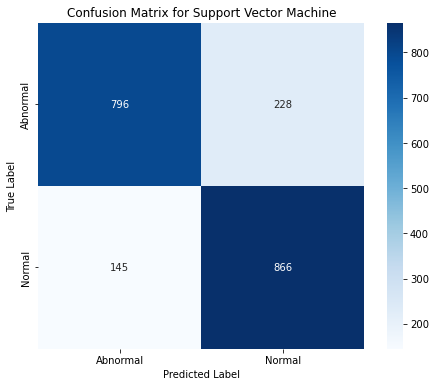

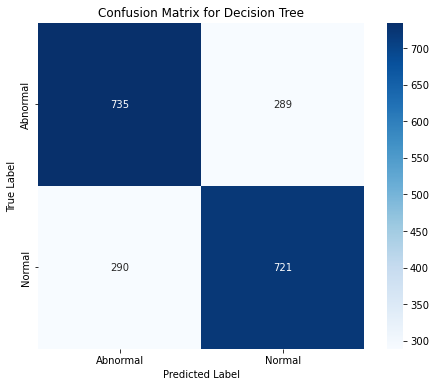

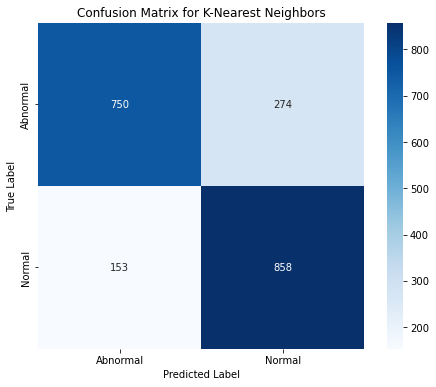

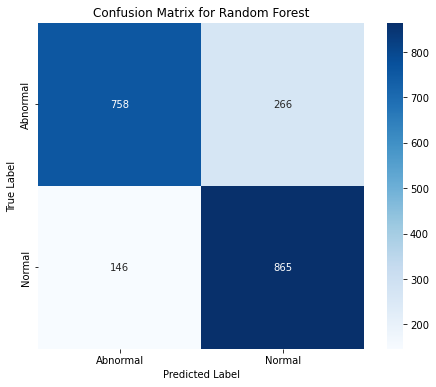

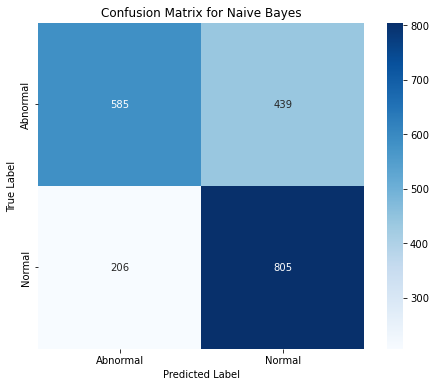

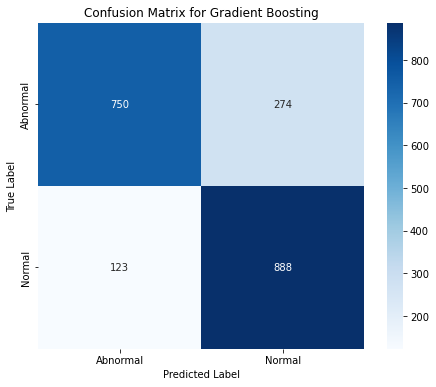

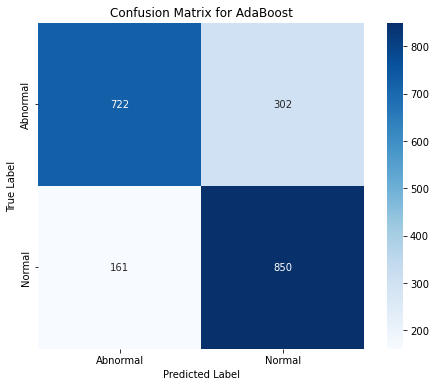

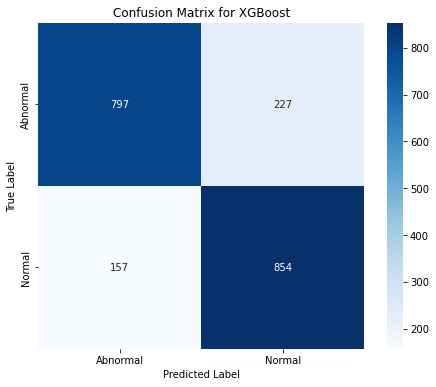

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrices(results):
    # Her sınıflandırıcı için bir Confusion Matrix çizdirme
    for name, result in results.items():
        plt.figure(figsize=(8, 6))
        sns.heatmap(result["confusion_matrix"], annot=True, fmt='d', cmap='Blues', square=True,
                    xticklabels=["Abnormal", "Normal"],
                    yticklabels=["Abnormal", "Normal"])
        plt.title(f'Confusion Matrix for {name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

plot_confusion_matrices(results)


# PCA

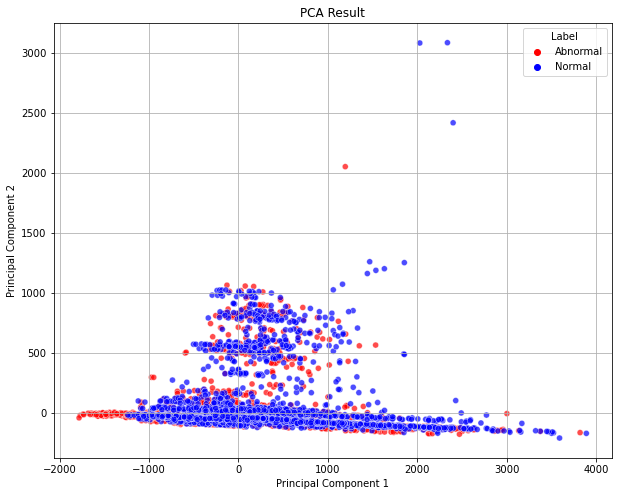

In [16]:
import pandas as pd 
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

def apply_pca_and_visualize(features, labels):
    # PCA modelini başlatma ve 2 ana bileşen ile veriyi dönüştürme
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(features)
    
    # PCA sonuçlarını bir DataFrame'e dönüştürme
    pca_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])
    pca_df['Label'] = labels  # Etiketleri DataFrame'e ekleme
    
    # Görselleştirme
    plt.figure(figsize=(10, 8))
    # Etiketlerin isimlerini ve renklerini belirleme
    label_colors = {0: 'red', 1: 'blue'}  # 0: abnormal, 1: normal
    label_names = {0: 'Abnormal', 1: 'Normal'}
    sns.scatterplot(x='Principal Component 1', y='Principal Component 2', hue='Label', data=pca_df,
                    palette=label_colors, alpha=0.7)
    plt.title('PCA Result')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    # Legend'ı ekleme
    handles, _ = plt.gca().get_legend_handles_labels()
    plt.legend(handles, ['Abnormal', 'Normal'], title='Label')
    plt.grid(True)
    plt.show()

# Özellik matrisi ve etiketleri kullanarak PCA uygulama ve görselleştirme
apply_pca_and_visualize(features_matrix, labels_matrix)



3 boyutlu da bakılsın.

# TSNE

C:\Users\Sema\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Sema\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


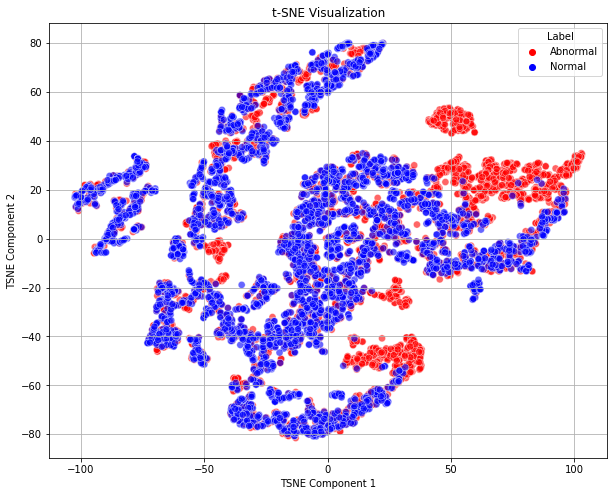

In [20]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def apply_tsne_and_visualize(features, labels):
    # TSNE modelini başlatma ve 2 boyutlu veriyi dönüştürme
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(features)
    
    # TSNE sonuçlarını bir DataFrame'e dönüştürme
    tsne_df = pd.DataFrame(data=tsne_results, columns=['TSNE Component 1', 'TSNE Component 2'])
    tsne_df['Label'] = labels  # Etiketleri DataFrame'e ekle
    
    # Görselleştirme
    plt.figure(figsize=(10, 8))
    label_colors = {0: 'red', 1: 'blue'}  # 0: abnormal, 1: normal
    scatter = sns.scatterplot(x='TSNE Component 1', y='TSNE Component 2', hue='Label', data=tsne_df,
                              palette=label_colors, alpha=0.6, s=50)
    
    # Legend ile ilgili
    plt.title('t-SNE Visualization')
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    legend_labels = ['Abnormal', 'Normal']
    handles, labels = scatter.get_legend_handles_labels()
    plt.legend(handles, legend_labels, title='Label')
    plt.grid(True)
    plt.show()

# Özellik matrisi ve etiketleri kullanarak t-SNE uygulama ve görselleştirme
apply_tsne_and_visualize(features_matrix, labels_matrix)



# Fine-tuning

5 Katlı Çapraz Doğrulama: Veri seti 5 alt kümeye bölünür ve model her alt küme için eğitilip değerlendirilir.

Parametre Kombinasyonları: Kullanıcı tarafından tanımlanan parametre ızgarasındaki her olası kombinasyon denenir. GridSearchCV veya RandomizedSearchCV bu kombinasyonları belirler ve her biri için modelin performansını değerlendirir.

* Veri seti, yaklaşık olarak eşit büyüklükte 5 alt kümeye (fold) bölünür.

* Eğitim ve Değerlendirme: Model, 5 kez eğitilir ve değerlendirilir. Her bir seferde, bir alt küme test seti olarak kullanılırken, kalan 4 alt küme eğitim seti olarak kullanılır.

* Ortalama Performans: Her bir değerlendirme sonucu kaydedilir ve sonrasında bu 5 değerlendirmenin ortalaması alınarak modelin genel performansı elde edilir.

- 5 ve 10 katlı çapraz doğrulama yaygın olarak kullanılır büyük Veri Setlerinde. Küçük Veri Setlerinde 10 -fold cross-validation.


Parametre Izgarasının Belirlenmesi
Parametre ızgarası, modelin hiperparametrelerini ayarlamak için kullanılacak değer aralıklarını ve kombinasyonları tanımlar. 

Modelin Hiperparametreleri:
Her modelin, performansını önemli ölçüde etkileyebilecek belirli hiperparametreleri vardır. Örneğin, RandomForestClassifier için n_estimators ve max_depth önemli hiperparametrelerdir.

Literatür ve Tecrübe:
Daha önce yapılan çalışmalardan ve modelleme tecrübelerinden faydalanılabilir.


Çok geniş bir parametre ızgarası, hesaplama maliyetini artırabilir. Dolayısıyla, genellikle önemli parametrelerin belirli değer aralıklarında, makul sayıda kombinasyon denenir.

* GridSearchCV tüm kombinasyonları denerken, RandomizedSearchCV belirli sayıda rastgele kombinasyon dener.

* 12 farklı kombinasyon denendi. Bu durumda:

C için 3 değer,
gamma için 1 değer,
kernel için 2 değer vardır.
Bu da 3 x 1 x 2 = 6 farklı kombinasyon oluşturur. Çıktıda belirtilen 12 kombinasyonun tam olarak nasıl belirlendiği, kullanılan parametre ızgarasına ve belirli parametrelerin deneme aralığına bağlıdır.


### RandomForestClassifier

GridSearchCV:

GridSearchCV, belirli bir parametre ızgarasını (grid) tarayarak en iyi parametreleri bulur. Her olası parametre kombinasyonu denenir. 

In [18]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Parametre dağılımını tanımla
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 50)
}

# RandomizedSearchCV objesi oluşturma
random_search = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42),
                                   param_distributions=param_dist,
                                   n_iter=10,  # 10 farklı kombinasyon denenecek
                                   cv=5,
                                   verbose=1,
                                   random_state=42,
                                   n_jobs=-1)

# Rastgele arama ile modeli eğitme
random_search.fit(X_train, y_train)

# En iyi parametreleri ve en iyi skoru göster
print("Best Parameters:", random_search.best_params_)
print("Best Cross-validation Score:", random_search.best_score_)

# Test seti üzerinde tahmin yapma
best_clf = random_search.best_estimator_
predictions = best_clf.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("Test Accuracy:", accuracy)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'max_depth': 41, 'n_estimators': 448}
Best Cross-validation Score: 0.8032760032760032
Test Accuracy: 0.8132678132678133


RandomizedSearchCV ile:

RandomizedSearchCV, belirli bir parametre dağılımından rastgele seçilen kombinasyonları deneyerek en iyi parametreleri bulur. 

In [21]:
from sklearn.model_selection import GridSearchCV

# RandomForest için parametre grid'i tanımlama
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None]
}

# GridSearchCV objesi oluşturma
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5,  # 5-fold cross-validation
                           verbose=1,  # İşlem sırasında bilgi vermesi için
                           n_jobs=-1)  # Tüm işlemcileri kullan

# Grid search ile modeli eğitme
grid_search.fit(X_train, y_train)

# En iyi parametreleri ve en iyi skoru göster
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation Score:", grid_search.best_score_)

# Test seti üzerinde tahmin yapma
best_clf = grid_search.best_estimator_
predictions = best_clf.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("Test Accuracy:", accuracy)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'max_depth': 20, 'n_estimators': 300}
Best Cross-validation Score: 0.8032760032760032
Test Accuracy: 0.8068796068796069


### SVC (Support Vector Machine)

GridSearchCV:

In [22]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10],  # Düzenleme parametresi
    'gamma': ['scale', 'auto'],  # Kernel katsayısı
    'kernel': ['rbf', 'linear']  # Kullanılacak kernel tipi
}

grid_search_svc = GridSearchCV(SVC(random_state=42), param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search_svc.fit(X_train, y_train)

print("Best Parameters for SVC:", grid_search_svc.best_params_)
print("Best Cross-validation Score:", grid_search_svc.best_score_)

predictions = grid_search_svc.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, predictions))


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters for SVC: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best Cross-validation Score: 0.823914823914824
Test Accuracy: 0.8343980343980344


RandomizedSearchCV:

In [23]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon

param_dist = {
    'C': expon(scale=100),  # Düzenleme parametresi için sürekli dağılım
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'linear']
}

random_search_svc = RandomizedSearchCV(SVC(random_state=42), param_dist, n_iter=10, cv=5, verbose=1, random_state=42, n_jobs=-1)
random_search_svc.fit(X_train, y_train)

print("Best Parameters for SVC:", random_search_svc.best_params_)
print("Best Cross-validation Score:", random_search_svc.best_score_)

predictions = random_search_svc.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, predictions))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for SVC: {'C': 5.983876860868068, 'gamma': 'auto', 'kernel': 'rbf'}
Best Cross-validation Score: 0.8257166257166257
Test Accuracy: 0.82997542997543


randomize cv ile genel bir parametre array'i oluştur. Best parametreleri al. bunlara yakın yeni bir parametre değeri oluşturup tekrar çalıştırıyorum. yeni çıkanlarla devam et.

### K-Nearest Neighbors (KNN) 

GridSearchCV:

In [24]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9],  # Komşu sayısı
    'weights': ['uniform', 'distance'],  # Ağırlık fonksiyonu
    'p': [1, 2]  # Minkowski metriği için güç parametresi (1: manhattan, 2: euclidean)
}

grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search_knn.fit(X_train, y_train)

print("Best Parameters for KNN:", grid_search_knn.best_params_)
print("Best Cross-validation Score:", grid_search_knn.best_score_)

predictions = grid_search_knn.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, predictions))


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters for KNN: {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Best Cross-validation Score: 0.7765765765765765
Test Accuracy: 0.797051597051597


RandomizedSearchCV:

In [25]:
param_dist = {
    'n_neighbors': randint(1, 20),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

random_search_knn = RandomizedSearchCV(KNeighborsClassifier(), param_dist, n_iter=10, cv=5, verbose=1, random_state=42, n_jobs=-1)
random_search_knn.fit(X_train, y_train)

print("Best Parameters for KNN:", random_search_knn.best_params_)
print("Best Cross-validation Score:", random_search_knn.best_score_)

predictions = random_search_knn.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, predictions))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for KNN: {'n_neighbors': 15, 'p': 1, 'weights': 'distance'}
Best Cross-validation Score: 0.7775593775593775
Test Accuracy: 0.7941031941031941


### Decision Tree Classifier

GridSearchCV:

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

grid_search_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search_dt.fit(X_train, y_train)

print("Best Parameters for Decision Tree:", grid_search_dt.best_params_)
print("Best Cross-validation Score:", grid_search_dt.best_score_)

predictions_dt = grid_search_dt.predict(X_test)
print("Test Accuracy for Decision Tree:", accuracy_score(y_test, predictions_dt))


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters for Decision Tree: {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
Best Cross-validation Score: 0.7374283374283375
Test Accuracy for Decision Tree: 0.7282555282555283


RandomizedSearchCV:

In [27]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10)
}

random_search_dt = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), param_dist, n_iter=10, cv=5, verbose=1, n_jobs=-1, random_state=42)
random_search_dt.fit(X_train, y_train)

print("Best Parameters for Decision Tree:", random_search_dt.best_params_)
print("Best Cross-validation Score:", random_search_dt.best_score_)

predictions_dt = random_search_dt.predict(X_test)
print("Test Accuracy for Decision Tree:", accuracy_score(y_test, predictions_dt))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for Decision Tree: {'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 12}
Best Cross-validation Score: 0.7351351351351351
Test Accuracy for Decision Tree: 0.7395577395577395


### Naive Bayes

GridSearchCV:

In [28]:
from sklearn.naive_bayes import GaussianNB

param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

grid_search_nb = GridSearchCV(GaussianNB(), param_grid_nb, cv=5, verbose=1, n_jobs=-1)
grid_search_nb.fit(X_train, y_train)

print("Best Parameters for Naive Bayes:", grid_search_nb.best_params_)
print("Best Cross-validation Score:", grid_search_nb.best_score_)

predictions_nb = grid_search_nb.predict(X_test)
print("Test Accuracy for Naive Bayes:", accuracy_score(y_test, predictions_nb))


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters for Naive Bayes: {'var_smoothing': 0.01873817422860384}
Best Cross-validation Score: 0.6792792792792792
Test Accuracy for Naive Bayes: 0.683046683046683


RandomizedSearchCV:

In [29]:
param_dist_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

random_search_nb = RandomizedSearchCV(GaussianNB(), param_dist_nb, n_iter=10, cv=5, verbose=1, n_jobs=-1, random_state=42)
random_search_nb.fit(X_train, y_train)

print("Best Parameters for Naive Bayes:", random_search_nb.best_params_)
print("Best Cross-validation Score:", random_search_nb.best_score_)

predictions_nb = random_search_nb.predict(X_test)
print("Test Accuracy for Naive Bayes:", accuracy_score(y_test, predictions_nb))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for Naive Bayes: {'var_smoothing': 0.01}
Best Cross-validation Score: 0.678951678951679
Test Accuracy for Naive Bayes: 0.683046683046683


# GradientBoostingClassifier

GridSearchCV:

In [30]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform

param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

grid_search_gb = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid_gb, cv=5, verbose=1, n_jobs=-1)
grid_search_gb.fit(X_train, y_train)

print("Best Parameters for Gradient Boosting:", grid_search_gb.best_params_)
print("Best Cross-validation Score:", grid_search_gb.best_score_)

predictions_gb = grid_search_gb.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, predictions_gb))


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
Best Cross-validation Score: 0.810974610974611
Test Accuracy: 0.8191646191646191


RandomizedSearchCV:

In [32]:
from scipy.stats import randint, uniform

param_dist_gb = {
    'n_estimators': randint(100, 300),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 6)
}

random_search_gb = RandomizedSearchCV(GradientBoostingClassifier(random_state=42), param_dist_gb, n_iter=10, cv=5, verbose=1, random_state=42, n_jobs=-1)
random_search_gb.fit(X_train, y_train)

print("Best Parameters for Gradient Boosting:", random_search_gb.best_params_)
print("Best Cross-validation Score:", random_search_gb.best_score_)

predictions_gb_rs = random_search_gb.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, predictions_gb_rs))



Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for Gradient Boosting: {'learning_rate': 0.06824582803960838, 'max_depth': 5, 'n_estimators': 269}
Best Cross-validation Score: 0.8055692055692056
Test Accuracy: 0.8186732186732186


# AdaBoostClassifier

GridSearchCV:

In [34]:
from sklearn.ensemble import AdaBoostClassifier

param_grid_ada = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0]
}

grid_search_ada = GridSearchCV(AdaBoostClassifier(random_state=42), param_grid_ada, cv=5, verbose=1, n_jobs=-1)
grid_search_ada.fit(X_train, y_train)

print("Best Parameters for AdaBoost:", grid_search_ada.best_params_)
print("Best Cross-validation Score:", grid_search_ada.best_score_)

predictions_ada = grid_search_ada.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, predictions_ada))


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters for AdaBoost: {'learning_rate': 1.0, 'n_estimators': 200}
Best Cross-validation Score: 0.7880425880425881
Test Accuracy: 0.7872235872235872


RandomizedSearchCV:

In [36]:
from scipy.stats import randint, uniform

param_dist_ada = {
    'n_estimators': randint(50, 200),
    'learning_rate': uniform(0.01, 1.0)
}

random_search_ada = RandomizedSearchCV(AdaBoostClassifier(random_state=42), param_dist_ada, n_iter=10, cv=5, verbose=1, random_state=42, n_jobs=-1)
random_search_ada.fit(X_train, y_train)

print("Best Parameters for AdaBoost:", random_search_ada.best_params_)
print("Best Cross-validation Score:", random_search_ada.best_score_)

predictions_ada_rs = random_search_ada.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, predictions_ada_rs))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for AdaBoost: {'learning_rate': 0.6111150117432088, 'n_estimators': 180}
Best Cross-validation Score: 0.7860769860769861
Test Accuracy: 0.7852579852579853


# XGBClassifier

GridSearchCV:

In [37]:
import xgboost as xgb

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

grid_search_xgb = GridSearchCV(xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42), param_grid_xgb, cv=5, verbose=1, n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

print("Best Parameters for XGBoost:", grid_search_xgb.best_params_)
print("Best Cross-validation Score:", grid_search_xgb.best_score_)

predictions_xgb = grid_search_xgb.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, predictions_xgb))


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300}
Best Cross-validation Score: 0.8185094185094185
Test Accuracy: 0.826044226044226


RandomizedSearchCV:

In [39]:
from scipy.stats import randint, uniform

param_dist_xgb = {
    'n_estimators': randint(100, 300),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 6)
}

random_search_xgb = RandomizedSearchCV(xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42), param_dist_xgb, n_iter=10, cv=5, verbose=1, random_state=42, n_jobs=-1)
random_search_xgb.fit(X_train, y_train)

print("Best Parameters for XGBoost:", random_search_xgb.best_params_)
print("Best Cross-validation Score:", random_search_xgb.best_score_)

predictions_xgb_rs = random_search_xgb.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, predictions_xgb_rs))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for XGBoost: {'learning_rate': 0.06824582803960838, 'max_depth': 5, 'n_estimators': 269}
Best Cross-validation Score: 0.8072072072072072
Test Accuracy: 0.8132678132678133


nanbinary classification. rullman, missalignment

* Sınıflandırıcı ekle: booster sınıflandırıcısı. xg boost. 
* feature selection: Recursive feature elimination

tablo hazırlanacak. satırlarda sınıflandırıcılar var. columnlarda parametre optimizasyonu yapılmış yapılmamış hali. feature extraction yapılmış yapılmamış hali gösterilsin.

merhaba bir proje yapıyorum. bu porjede endüstriyel makinaların çıkardıkları sesleri kullanarak bu sesler üzerinden sesin normal veya anormal olduğunu tespit edip anormal seslerin ne gibi bir hatadan kaynaklı olduğunu bulacağım. şu an için projenin çok başındayım. wav dosyalarından oluşan bir klasörüm var için 407 tane abnormal 407 tane de normal ses çıkaran makinaların sesleri var. bu sesleri işleyip değerlendirip hata kodu etiketleme aşamasına geçeceğim. şu an için ses verilerini time series'e ve fft'ye çevirerek normal ve anormal arasındaki farkı gözlemledim. kod için python kullanıyorum. sonrasında feature extarction yöntemleri uyguladım bu seslere.her bir ses dosyasından şu an için 10 örnek aldım yani toplam 814 tane ses dosyamın her birinden 10 tane rastgele örnek seçtim ve feature extraction yöntemleri uyguladım. kullandığım feature extraction yöntemleri şunlar: spectral_centroid, spectral_rolloff, spectral_bandwidth, spectral_flatness, Zero Crossing Rate, MFCC, Chromagram, total_power, max_power_freq, Band Power. Bu yöntemleri uyguladıktan sonra çıkan sonuçları bir data matrixinde depoladım. sonra ayrı bir data matrixinde bu ses dosyalarını labelladım. abnormallere 0, normallere 1 verdim ve feature extraction sonuçlarının olduğu data matrixi ile bu label data matrixini indexledim doğru sonuçlar vermesi için. Sonra sınıflandırıcıarı uygulamaya başladım. Hikayem bu şekilde. Şimdi bu uyguladığım sınıflandırıcılara ek olarak yeni sınıflandırıcıların uygulanmasını talep edeceğim senden. uygulamanı istediğim sınıflandırıcılar: gradient boosting, adaboost ve Xgboost sınıflandırıcılarını bu koda ekleyebilir misin.

Son kod bu şekildeydi:


şimdi bu yeni eklediğim sınıflandırcılara ayrı ayrı GridSearchCV ve RandomizedSearchCV ile fine tunning uygulamak istiyorum. uygulamak istediğim sınıflandırıcılar şunlar:  gradient boosting, adaboost ve Xgboost . daha önceden diğer sınıflandırıcılara fine tunning uygulamıştım onlardan benzer bir kod vereyim sana mesela SVM'ye uyguladığım fine tunning:


